# Using KNN to do Predictions in the Adult Dataset
## PMR3508: Machine Learning and Pattern Recogniation
## Student name: Rodolfo Lima (PMR3508-2021-6)

## 0- Libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

#Sklearn functions
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

## 1- Data Cleaning

In [2]:
#Training data
df_train = pd.read_csv('train_data.csv')
df_train = df_train.set_index('Id')

#testing Data
df_test = pd.read_csv("adult.test.txt",
names=['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
        sep=r'\s*,\s*',
        engine='python')
df_test.drop(df_test.index[0], axis = 0, inplace = True)
df_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [4]:
# First, I've to check the labels of categorical variables and values of quantitative variables in order to assess the integrity of my dataset
features = df_train.columns

#for feature in features:
    #print('Feature '+feature + ' values:',set(df_train[feature]))


In [71]:
# I have to deal with "?" strings in categorical variables and possible missing data
df_train = df_train.replace('?', np.nan)
df_test = df_test.replace('?', np.nan)
rows_nan = []
for index,row in df_train.isnull().iterrows():
    if (row.values).any():
        rows_nan.append(index)
len(rows_nan)  #number of rows  that have any missing data              

2399

In [74]:
# I have to get rid of '.' in the income column of the test dataset
df_test['income'] = df_test['income'].apply(lambda string: string.replace('.',''))
df_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
5,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [75]:
print('Rows that have any missing value: ',str(round((len(rows_nan)/df_train.shape[0])*100,1)) + '%')

Rows that have any missing value:  7.4%


In [76]:
#Owing to the small % of rows having missing data, I'll get rid of them
df_train = df_train.dropna(axis = 0)
display(df_train)

df_test = df_test.dropna(axis = 0)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48835,42,Private,384236,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,40,United-States,>50K
48836,23,Private,129042,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Black,Female,0,0,40,United-States,<=50K
48837,30,Private,195488,HS-grad,9,Never-married,Priv-house-serv,Own-child,White,Female,0,0,40,Guatemala,<=50K


In [82]:
#I will delete education columns once I already have 'education.num'
df_train.drop(labels = 'education', axis = 1, inplace = True)
df_test.drop(labels = 'education', axis = 1, inplace = True)

## 2- Exploratory Data Analysis (EDA) and Data Preparation

### 2.1 - Correlation Matrix

- Our target is the income, it's a categorical variable with two label
- I'm changing the target in order to have two quantiative value: 0 to <=50 and >50 to 1. Then, I'll able to measure the correlations among the variables

In [83]:
df_train_corr = df_train.copy()
df_train_corr['income']  =df_train_corr['income'].apply(lambda x: 0 if x == '<=50K' else 1 )
set(df_train_corr['income'])

{0, 1}

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text yticklabel objects>)

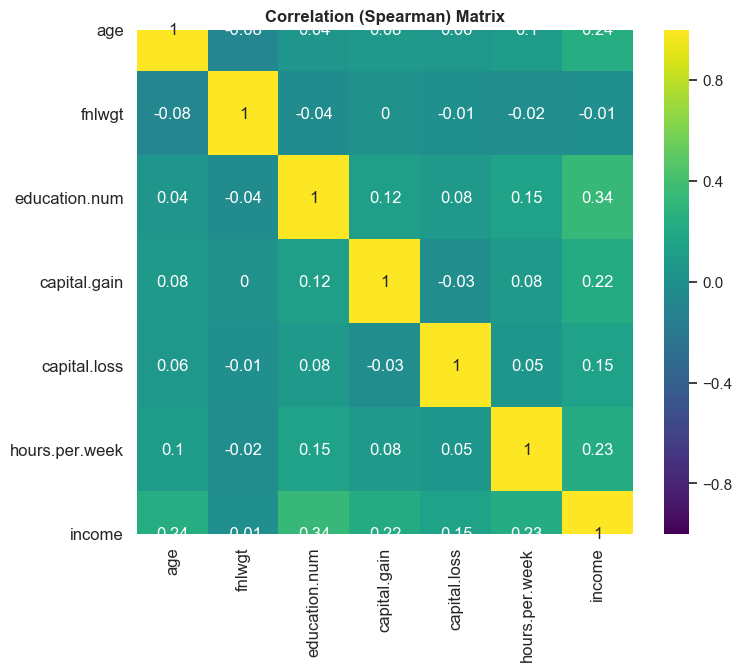

In [84]:
sea.heatmap(round(df_train_corr.corr(),2), annot = True,cmap = 'viridis',vmin = -1, vmax = 1)
plt.title("Correlation (Spearman) Matrix", fontweight = 'bold', fontsize = 12)

#Setting
plt.gcf().set_size_inches(8,8)
plt.gcf().set_dpi(100)
plt.subplots_adjust(bottom = .25)
plt.xticks(size = 12)
plt.yticks(size = 12)

- Comparing the target with other features, we can see the pearson correlation between income and fnlwgtg is close to 0. So we can considerer take this feature out

In [85]:
df_train.drop(labels = 'fnlwgt', axis =1, inplace = True)
df_test.drop(labels = 'fnlwgt', axis =1, inplace = True)

In [86]:
df_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,
16280,34,Private,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


### 2.2 - Analyzing quantitative features

In [87]:
display(df_train.head())
quant_features = ['age','education.num','capital.gain', 'capital.loss','hours.per.week']

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,
16280,34,Private,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

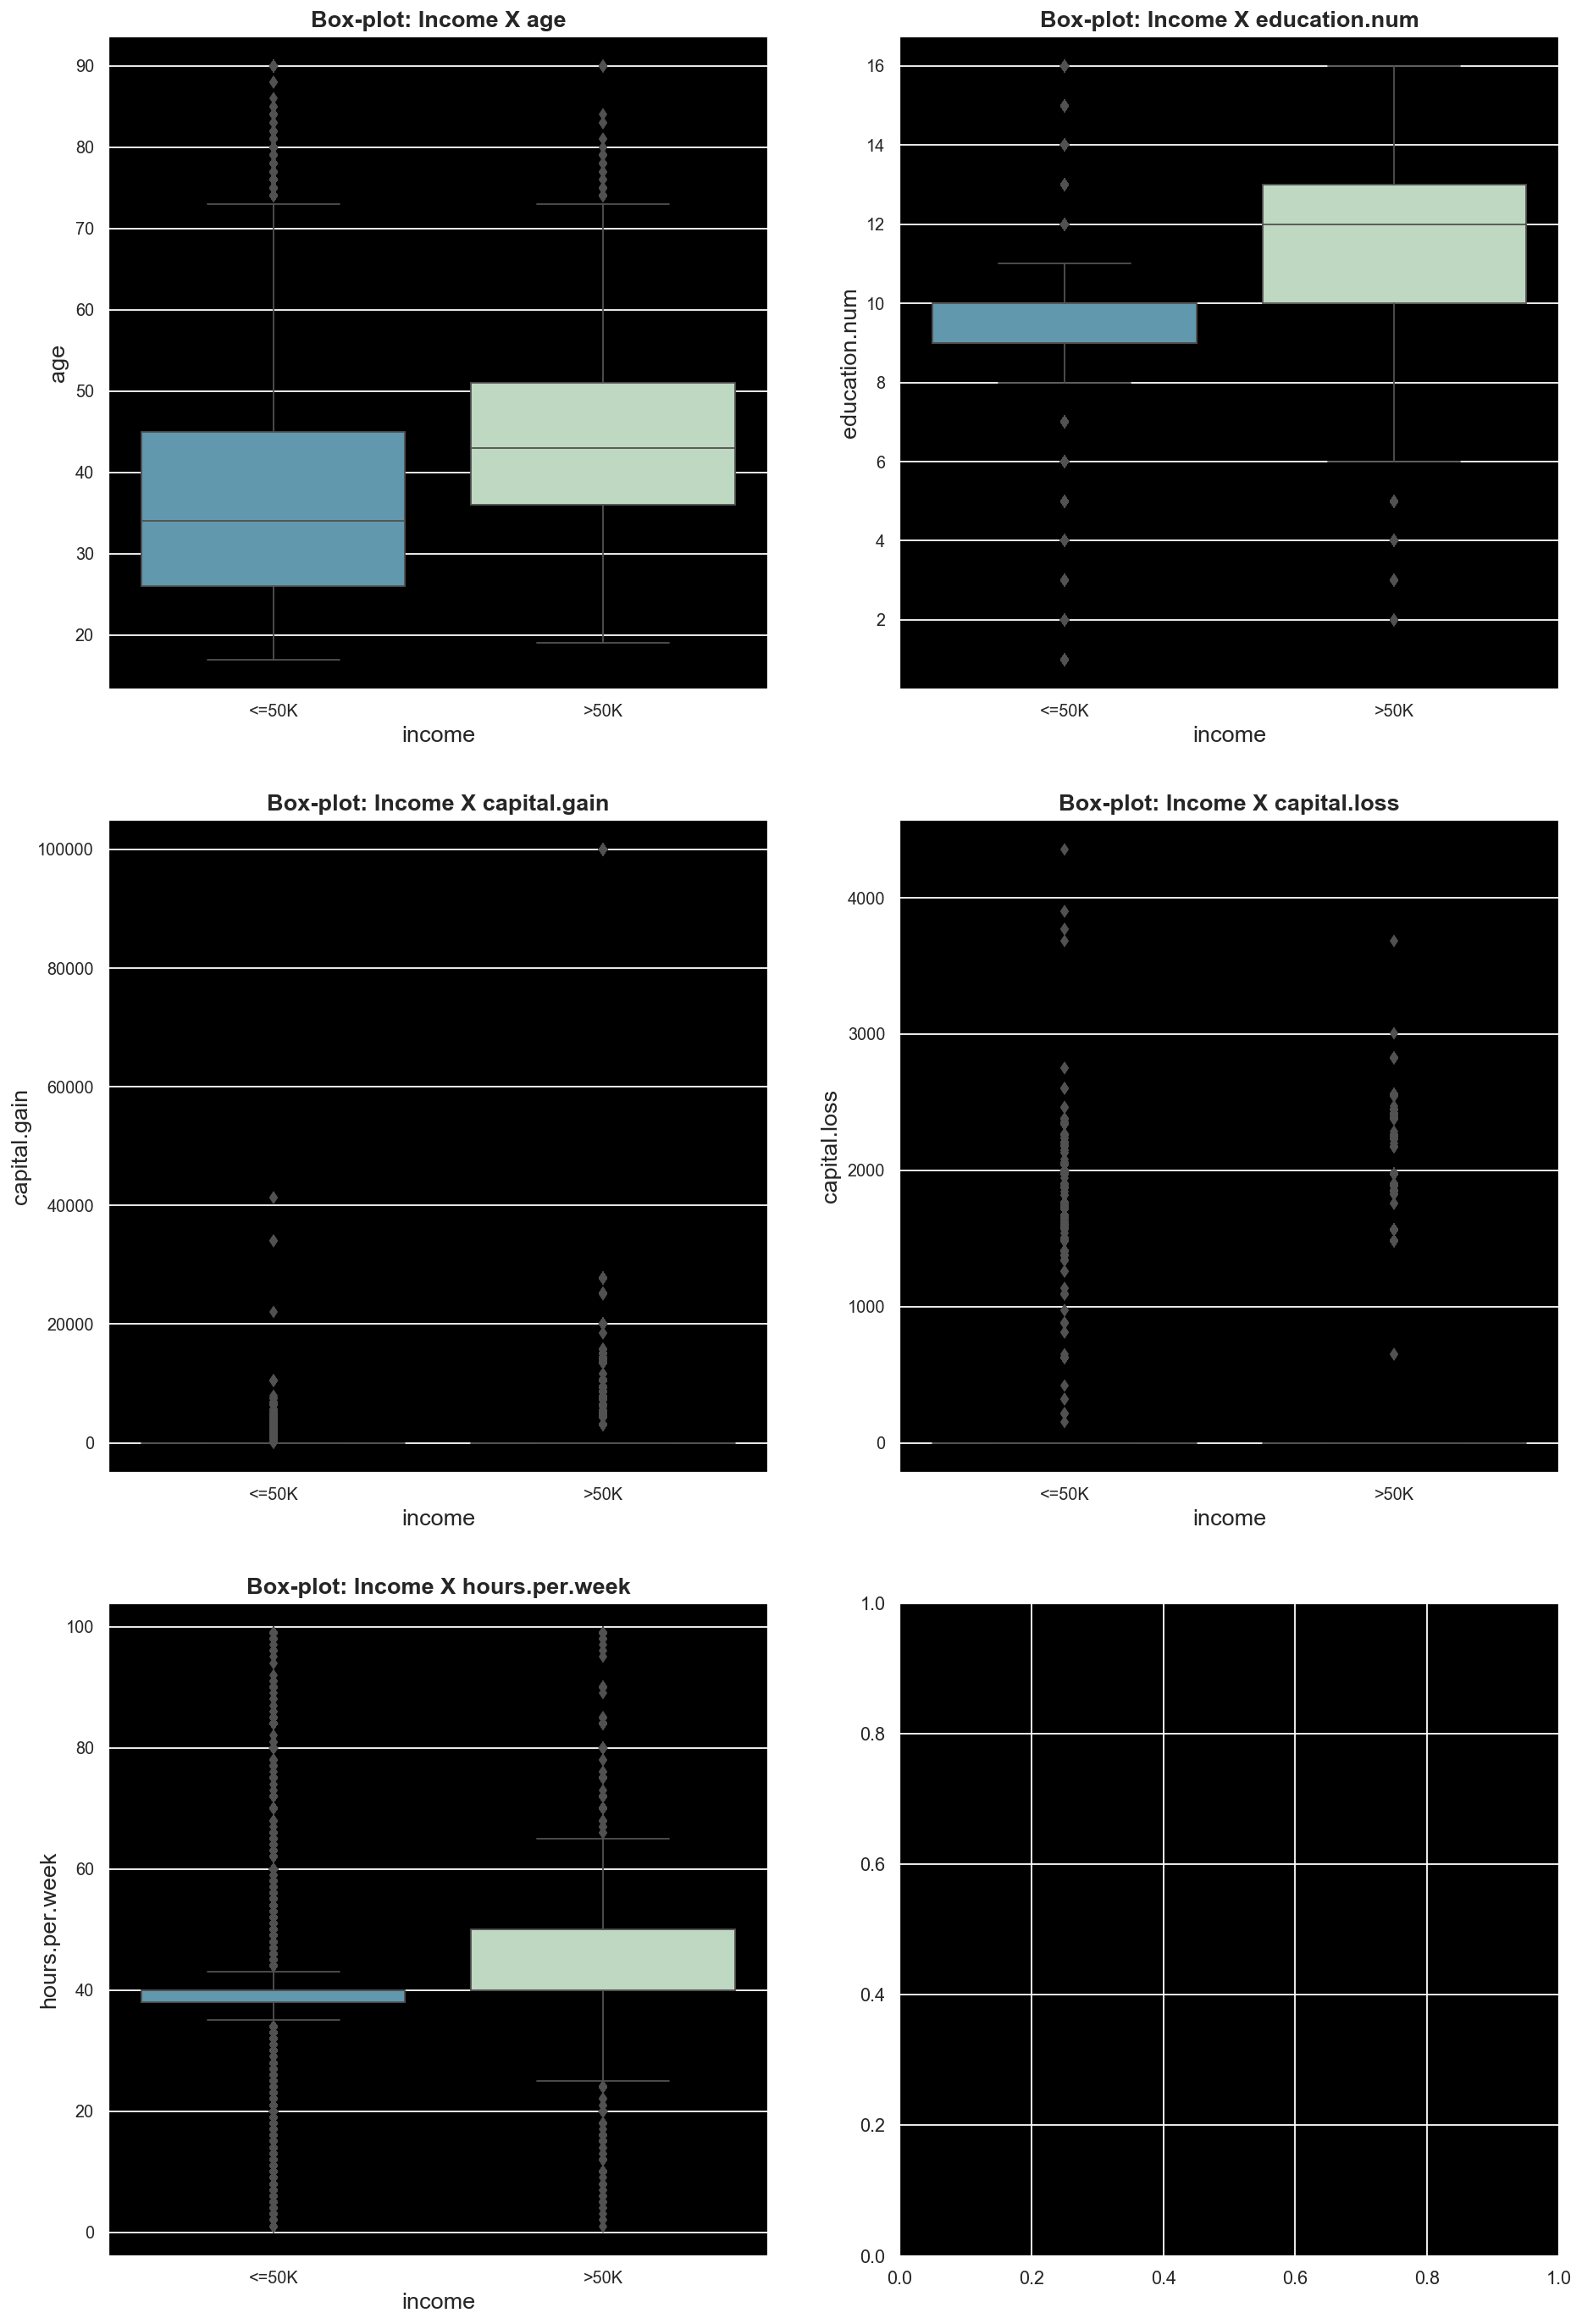

In [88]:
sea.set(rc = {'axes.facecolor':'black'} )
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
axes = [ax1,ax2,ax3,ax4,ax5,ax6]


for feature,ax in zip(quant_features,axes):
    
    #Plotting
    sea.boxplot(data = df_train, x = 'income', y =feature, palette = "GnBu_r", orient = "v", linewidth = 1, saturation= 0.56, ax= ax)
    #sea.swarmplot(data = df_train, x = 'income', y = feature, palette = 'GnBu_r', orient = 'v', size = 7,alpha= 1, edgecolor= 'grey', ax = ax)
    ax.set_xlabel('income', fontsize = 15)
    ax.set_ylabel(feature, fontsize = 15)
    ax.set_title("Box-plot: Income X {}".format(feature) ,size = 15, fontweight = 'bold')
       
    
#Setting
plt.gcf().set_size_inches(17,12)
plt.gcf().set_dpi(130)
plt.subplots_adjust(bottom = -0.8)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

- We can realize there are many outliers from the boxplots that need to be handled
- I'm using Robust Scaler method to deal with outliers

In [89]:
df_train[['capital.gain', 'capital.loss', 'hours.per.week']] = RobustScaler().fit_transform(df_train[['capital.gain', 'capital.loss', 'hours.per.week']])
df_test[['capital.gain', 'capital.loss', 'hours.per.week']] = RobustScaler().fit_transform(df_test[['capital.gain', 'capital.loss', 'hours.per.week']])

### 2.3 - Analyzing qualitative features

In [90]:
display(df_train.head())
qual_features = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,
16280,34,Private,10,Divorced,Exec-managerial,Own-child,White,Male,0.0,0.0,0.8,United-States,<=50K
16281,58,Local-gov,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,0.0,United-States,<=50K
16282,25,Private,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0.0,0.0,0.4,United-States,<=50K
16283,24,Private,10,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,0.0,United-States,<=50K
16284,57,Self-emp-inc,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178.0,0.0,4.0,Hungary,>50K


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

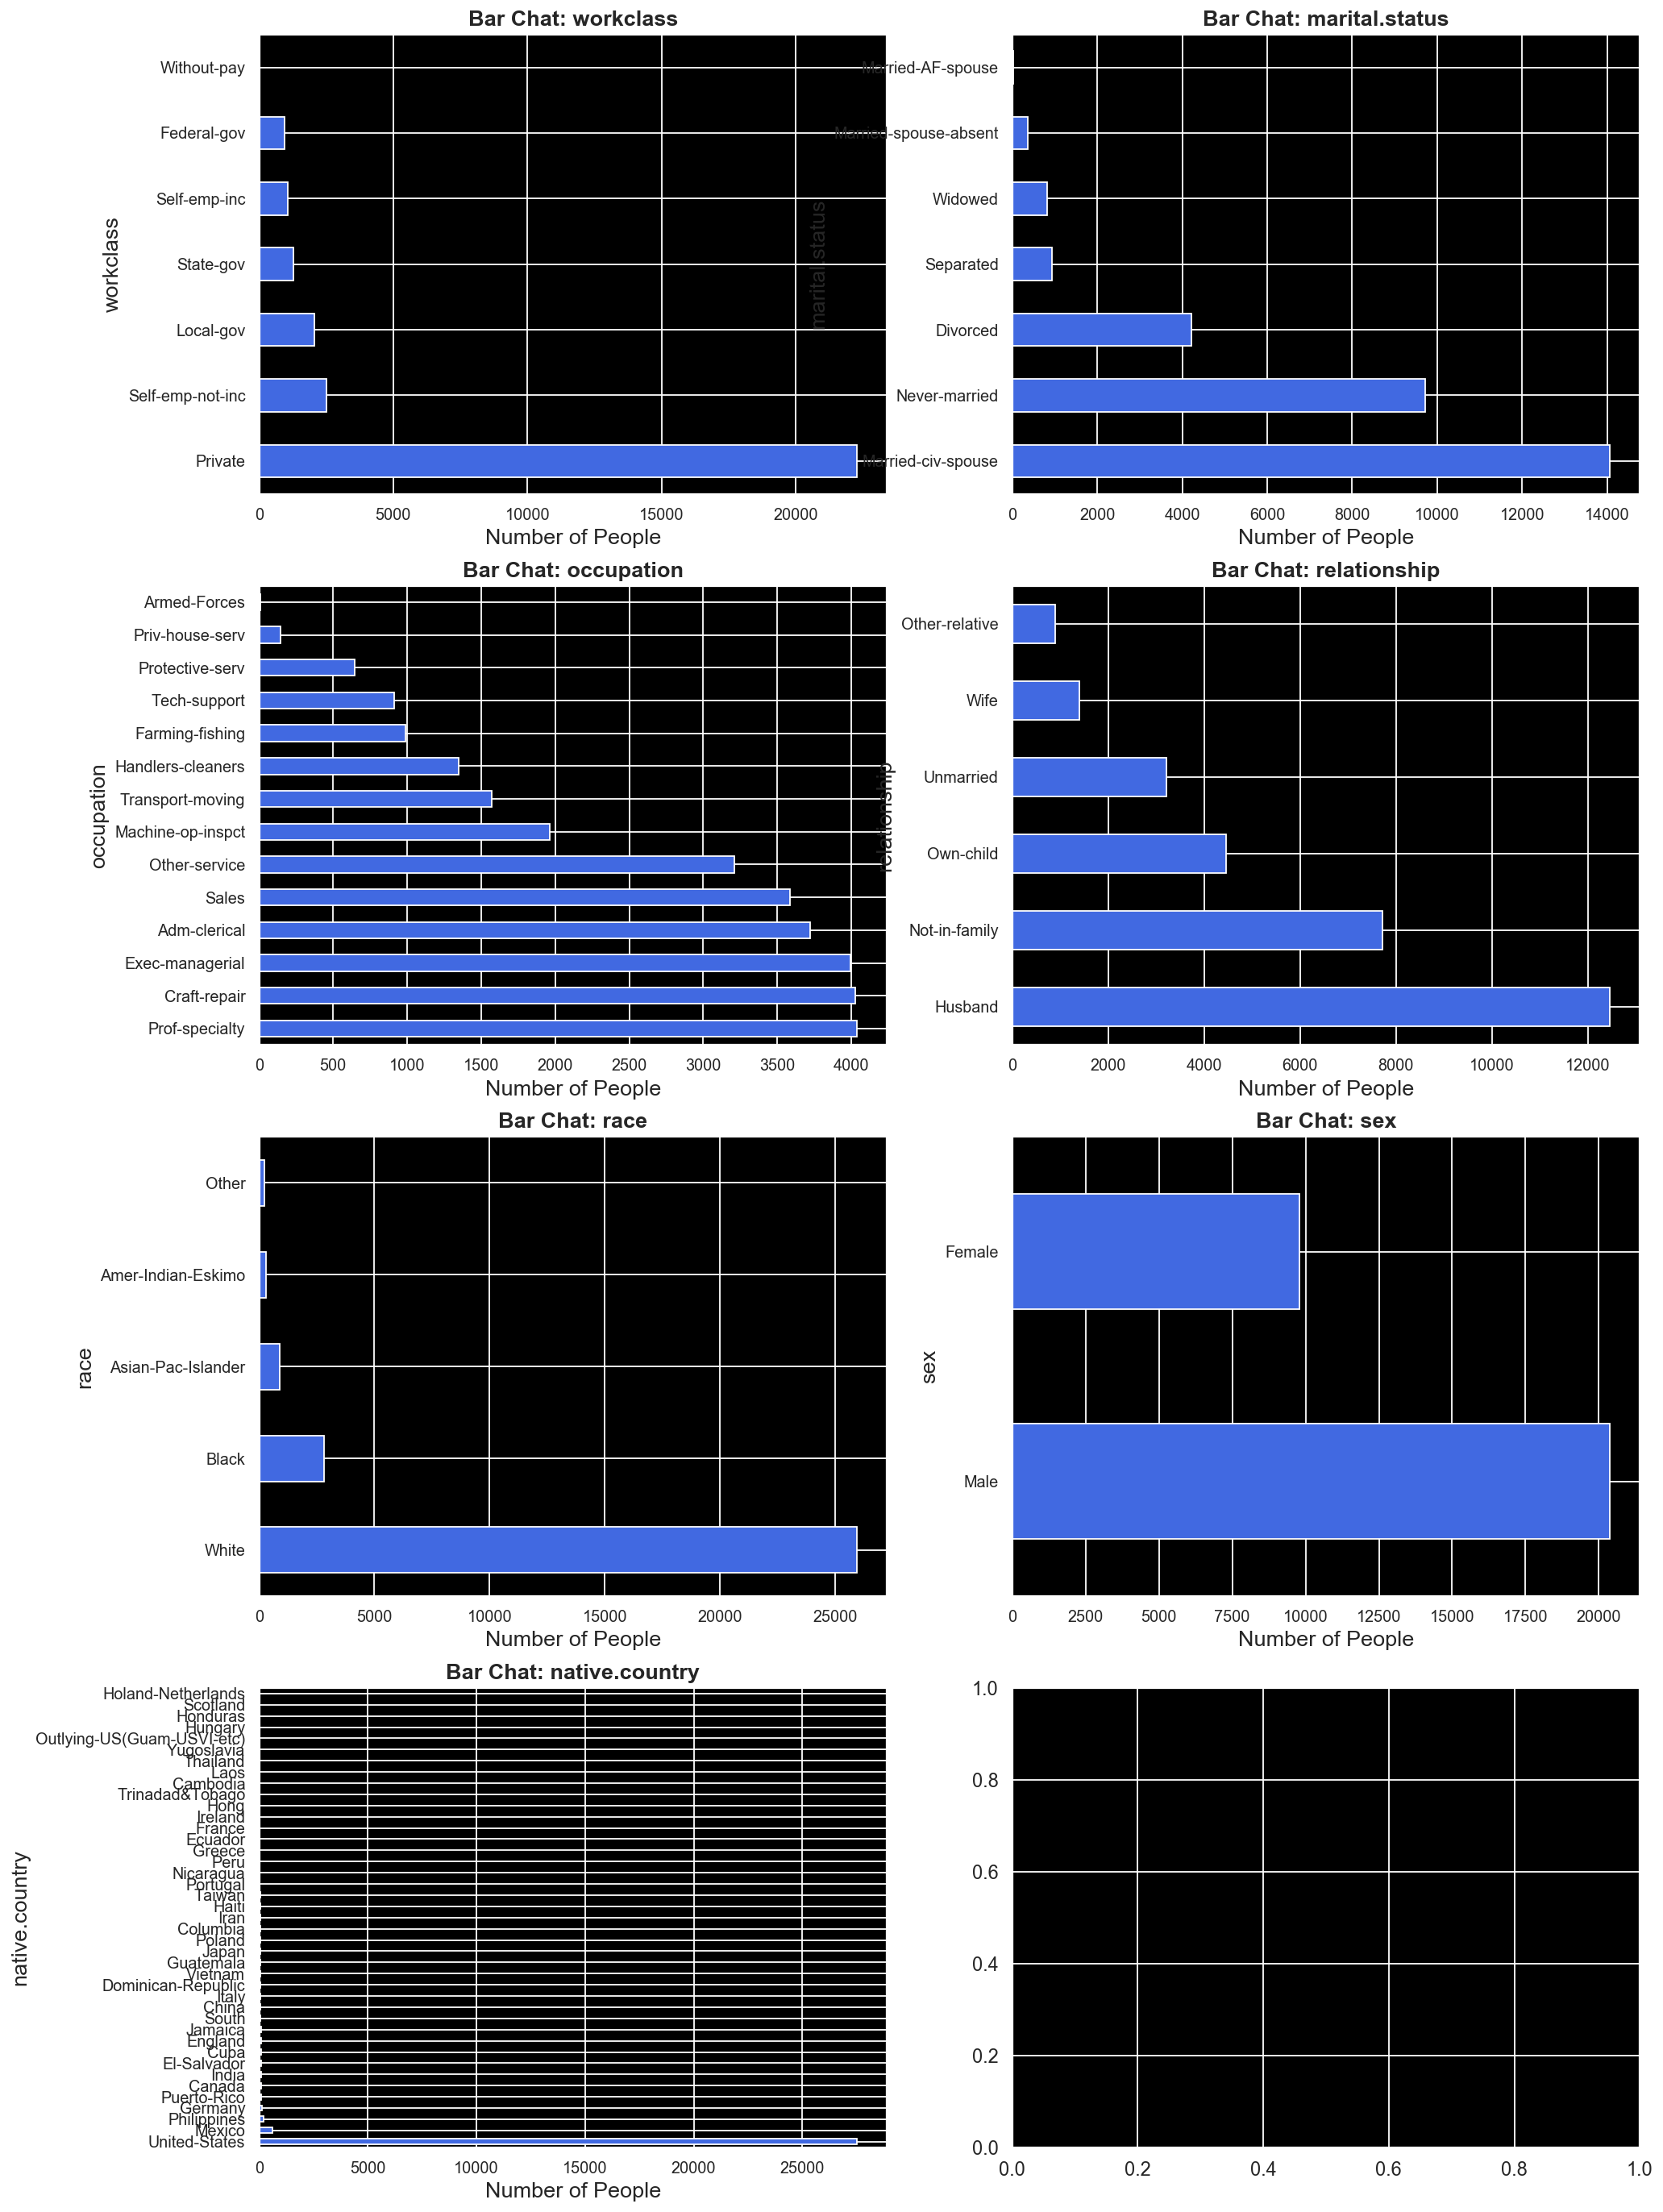

In [91]:
sea.set(rc = {'axes.facecolor':'black'} )
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8)) = plt.subplots(4,2)
axes = [ax1,ax2,ax3,ax4,ax5,ax6, ax7, ax8]


for feature,ax in zip(qual_features,axes):
    
    #Plotting
    df_train[feature].value_counts().plot.barh( color = 'royalblue', ax = ax)
    ax.set_xlabel('Number of People', fontsize = 15)
    ax.set_ylabel(feature, fontsize = 15)
    ax.set_title("Bar Chat: {}".format(feature) ,size = 15, fontweight = 'bold')
       
    
#Setting
plt.gcf().set_size_inches(17,12)
plt.gcf().set_dpi(130)
plt.subplots_adjust(bottom = -0.8)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

- The fact that catch my attention the most is the too way greater number of records from the US

In [92]:
df_train.groupby(by = 'native.country').agg({'native.country': lambda x: str(round(np.count_nonzero(x)/len(df_train) * 100,2)) + ' %'})

,native.country
native.country,
Cambodia,0.06 %
Canada,0.35 %
China,0.23 %
Columbia,0.19 %
Cuba,0.31 %
Dominican-Republic,0.22 %
Ecuador,0.09 %
El-Salvador,0.33 %
England,0.29 %


- We can notice that ony the United-States accounts for more than **91%** of the dataset records. We can conclude that the dataset is totally unballanced
- Very well. I'll handle it placing 1 to people from the US and 0 to non people from the US

In [93]:
df_train['USA'] = df_train['native.country'].apply(lambda x: 1 if x == 'United-States' else 0 )
df_test['USA'] = df_test['native.country'].apply(lambda x: 1 if x == 'United-States' else 0 )

- Now I have to convert the labels to numerical values in order to apply the KNN classifier

In [94]:
#training dataset
for feature in qual_features:
    df_train[feature] = LabelEncoder().fit_transform(df_train[feature])
    
#Test dataset    
for feature in qual_features:
    print(feature)
    df_test[feature] = LabelEncoder().fit_transform(df_test[feature])

workclass
marital.status
occupation
relationship
race
sex
native.country


In [95]:
df_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,USA
Id,,,,,,,,,,,,,,
16280,34,2,10,0,3,3,4,1,0.0,0.0,0.8,38,<=50K,1
16281,58,1,6,2,13,0,4,1,0.0,0.0,0.0,38,<=50K,1
16282,25,2,10,4,6,1,4,1,0.0,0.0,0.4,38,<=50K,1
16283,24,2,10,0,0,1,4,0,0.0,0.0,0.0,38,<=50K,1
16284,57,3,9,2,13,0,4,1,5178.0,0.0,4.0,17,>50K,0


## 3- Using KNN (K-Nearest Nighbor) Cassifier to Predict People's Income

### 3.1- Feature Selection

In [96]:
df_train.columns

Index(['age', 'workclass', 'education.num', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'native.country', 'income', 'USA'],
      dtype='object')

In [97]:
feature_select = ['age', 'workclass', 'education.num', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'USA']
target = 'income'

x_train = df_train[feature_select]
y_train = df_train[target]
x_test = df_test[feature_select]
y_test = df_test[target]

### 3.2 Applyig the Classifier to the training dataset

In [100]:
#I'm using cross validation method with 10 folders to select K that presents more accuracy
KN = np.arange(10, 16, 1)
for K in KN:
    score = cross_val_score(KNeighborsClassifier(n_neighbors = K), x_train, y_train, cv = 10, scoring = 'accuracy').mean()
    print(f'K-Neighbor: {K} | Accuracy: {score}')

K-Neighbor: 10 | Accuracy: 0.85103284531966
K-Neighbor: 11 | Accuracy: 0.8511650096077448
K-Neighbor: 12 | Accuracy: 0.8500049058541709
K-Neighbor: 13 | Accuracy: 0.8514305034184595
K-Neighbor: 14 | Accuracy: 0.8513974239146282
K-Neighbor: 15 | Accuracy: 0.8510327683393977


- I pick up the K that presents the best accuracy

### 3.3- Applyig the Classifier to the testing dataset

In [111]:
K = 10
knn = KNeighborsClassifier(n_neighbors = K)
knn.fit(x_train,y_train)
y_predict= knn.predict(x_test) #classification in practice

In [112]:
y_predict

array(['<=50K', '<=50K', '>50K', ..., '>50K', '<=50K', '>50K'],
      dtype=object)

In [113]:
#Classification accuracy
accuracy_score(y_test, y_predict)

0.8531208499335989

### 3.4 Saving Results

In [29]:
df_sub = pd.DataFrame({'Id': df_test.index, 'income': y_predict}, index = df_test.index)
df_sub

,Id,income
1,1,<=50K
2,2,<=50K
3,3,>50K
4,4,>50K
6,6,<=50K
...,...,...
16276,16276,<=50K
16277,16277,<=50K
16279,16279,>50K
16280,16280,<=50K


In [30]:
df_sub.to_csv('submission_rodolfo.csv', index = False)